# Assignment 11 - Viraj Noorithaya


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "production"

# WHich branch are you working on?
branch_name = "week-11" if code_mode == "development" else "main"
folder_name = "Session 11/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    # !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder
    !{sys.executable} -m pip install torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
    !{sys.executable} -m pip install grad-cam

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.8-py3-none-any.whl size=38247 sha256=178c9106b5e92b30d2d7dee60b1b215fb917b971eb9b30928ea295b3d630fe62
  Stored in directory: /root/.cache/pip/wheels/f8/04/36/94ff3c8a4215826a21946b34c01180817e606989fdf53f7cd6
Successfully built grad-cam


## Code Procurement


In [3]:
import sys
import os

# Current working directory
print(f"CWD: {os.getcwd()}")

# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

    # Make custom modules available
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: /content
Cloning into 'era-v1'...
remote: Enumerating objects: 1464, done.
remote: Counting objects: 100% (480/480), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 1464 (delta 255), reused 326 (delta 162), pack-reused 984
Receiving objects: 100% (1464/1464), 10.08 MiB | 19.71 MiB/s, done.
Resolving deltas: 100% (748/748), done.
Branch 'week-11' set up to track remote branch 'week-11' from 'origin'.
Switched to a new branch 'week-11'
Appending folder to path in order to detect modules: Session 11/Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [5]:
# Import user defined modules
from models.resnet import ResNet18 as Net
from models.resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES, get_cifar_dataloaders
from modules.trainer import find_optimal_lr, train_and_test_model
from modules.utils import get_device, get_num_workers, pretty_print_metrics, save_model
from modules.visualize import (
    plot_gradcam_images,
    plot_misclassified_images,
    plot_sample_training_images,
    plot_train_test_metrics,
)

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Script Parameters


In [6]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data?
data_path = "../../data"

# Specify the number of epochs
NUM_EPOCHS = 20

# Set the batch size
BATCH_SIZE = 512

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 3e-2
PREFERRED_WEIGHT_DECAY = 1e-5

# Set seed value for reproducibility
SEED = 26

# Expected accuracy
TARGET_ACCURACY = 85.0

## Get Device and Workers


In [7]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()

# How many workers do you need?
num_workers = get_num_workers(model_run_location)

print(
    f"Run location: {model_run_location}, \n",
    f"Device: {device_support}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {BATCH_SIZE} \n",
    f"Seed: {SEED} \n",
    f"Data path: {data_path}",
)

Run location: colab, 
 Device: cuda, 
 Number of workers: 2, 
 Batch size: 512 
 Seed: 26 
 Data path: ../../data


### Reproducibility settings


In [8]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## Dataloaders


In [9]:
# Get the train and test loader
# Transformations for the train and test data is present in dataset.py
train_loader, test_loader = get_cifar_dataloaders(
    data_path=data_path, batch_size=BATCH_SIZE, num_workers=num_workers, seed=SEED
)

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

100%|██████████| 170498071/170498071 [00:13<00:00, 12925556.38it/s]


Extracting ../../data/cifar-10-python.tar.gz to ../../data
Files already downloaded and verified
Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


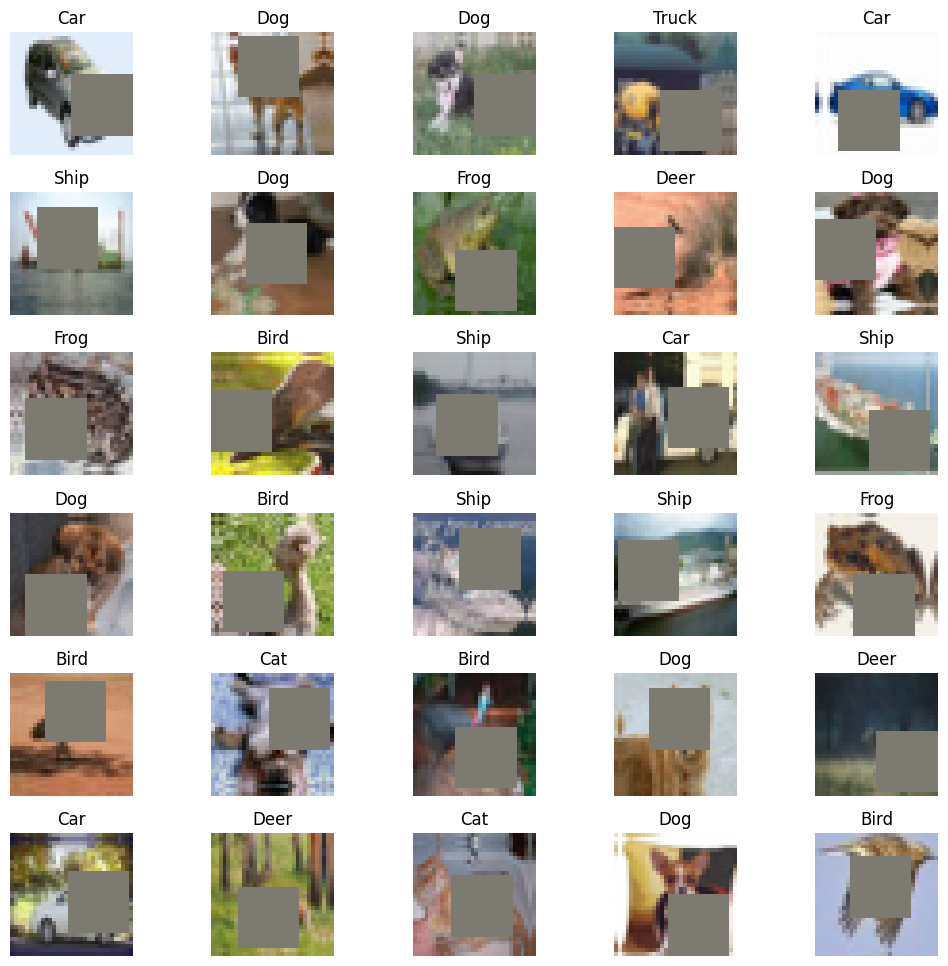

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(batch_data, batch_label, class_label=classes, num_images=30)
plt.show()

## Model Summary


In [11]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1 
	 torch.Size([1, 64, 32, 32]) 

Layer 2 
	 torch.Size([1, 128, 16, 16]) 

Layer 3 
	 torch.Size([1, 256, 8, 8]) 

Layer 4 
	 torch.Size([1, 512, 4, 4]) 

Post GAP 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
ResNet                                   [1, 3, 32, 32]   --               [1, 10]          --               True
├─Conv2d: 1-1                            [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
├─Sequential: 1-3                        [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]  --               [1, 64, 32, 32]  --      

## Train and Test


### Optimizer and Loss Function


In [12]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.70E-02


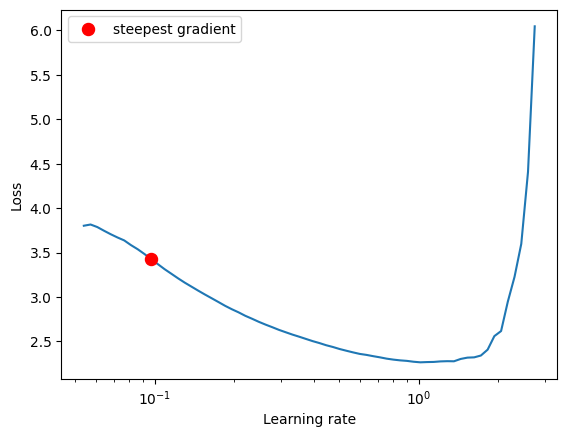

In [13]:
# Find optimal LR to start with
suggested_lr = find_optimal_lr(model, optimizer, criterion, train_loader)

### Scheduler


In [14]:
# suggested_lr = 0.2
print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=100,
    three_phase=False,
    anneal_strategy="linear",
    final_div_factor=100,
    verbose=False,
)

Suggested Max LR: 0.0970049125561403


### Train and test model


In [15]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 20


Epoch 1


Train: Loss=1.4337, Batch=97, Accuracy=36.21: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0030,  Accuracy: 44.56%


Epoch 2


Train: Loss=1.1994, Batch=97, Accuracy=49.98: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0025,  Accuracy: 56.39%


Epoch 3


Train: Loss=1.1137, Batch=97, Accuracy=57.65: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0023,  Accuracy: 60.78%


Epoch 4


Train: Loss=1.0217, Batch=97, Accuracy=62.53: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0019,  Accuracy: 67.39%


Epoch 5


Train: Loss=0.8932, Batch=97, Accuracy=66.57: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0017,  Accuracy: 71.29%


Epoch 6


Train: Loss=0.8213, Batch=97, Accuracy=69.68: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0019,  Accuracy: 68.04%


Epoch 7


Train: Loss=0.7661, Batch=97, Accuracy=71.08: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0017,  Accuracy: 70.69%


Epoch 8


Train: Loss=0.7228, Batch=97, Accuracy=73.26: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0019,  Accuracy: 68.71%


Epoch 9


Train: Loss=0.7051, Batch=97, Accuracy=74.38: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0014,  Accuracy: 77.06%


Epoch 10


Train: Loss=0.7024, Batch=97, Accuracy=75.83: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0016,  Accuracy: 74.44%


Epoch 11


Train: Loss=0.6908, Batch=97, Accuracy=77.65: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0014,  Accuracy: 77.51%


Epoch 12


Train: Loss=0.5731, Batch=97, Accuracy=78.39: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0014,  Accuracy: 78.39%


Epoch 13


Train: Loss=0.5198, Batch=97, Accuracy=79.46: 100%|██████████| 98/98 [00:41<00:00,  2.34it/s]


Test set: Average loss: 0.0010,  Accuracy: 83.39%


Epoch 14


Train: Loss=0.6079, Batch=97, Accuracy=80.24: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0011,  Accuracy: 82.04%


Epoch 15


Train: Loss=0.6192, Batch=97, Accuracy=80.60: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0013,  Accuracy: 79.45%


Epoch 16


Train: Loss=0.5042, Batch=97, Accuracy=81.74: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0009,  Accuracy: 84.45%


Epoch 17


Train: Loss=0.5182, Batch=97, Accuracy=82.19: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0014,  Accuracy: 77.85%


Epoch 18


Train: Loss=0.4672, Batch=97, Accuracy=82.61: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0013,  Accuracy: 81.31%


Epoch 19


Train: Loss=0.5498, Batch=97, Accuracy=83.19: 100%|██████████| 98/98 [00:41<00:00,  2.36it/s]


Test set: Average loss: 0.0011,  Accuracy: 81.42%


Epoch 20


Train: Loss=0.4355, Batch=97, Accuracy=83.44: 100%|██████████| 98/98 [00:41<00:00,  2.35it/s]


Test set: Average loss: 0.0010,  Accuracy: 84.03%




In [16]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 1.7233, Test Loss: 0.0030, Train Accuracy: 36.2140, Test Accuracy: 44.5600
Epoch: 02, Train Loss: 1.3658, Test Loss: 0.0025, Train Accuracy: 49.9820, Test Accuracy: 56.3900
Epoch: 03, Train Loss: 1.1699, Test Loss: 0.0023, Train Accuracy: 57.6500, Test Accuracy: 60.7800
Epoch: 04, Train Loss: 1.0446, Test Loss: 0.0019, Train Accuracy: 62.5260, Test Accuracy: 67.3900
Epoch: 05, Train Loss: 0.9349, Test Loss: 0.0017, Train Accuracy: 66.5700, Test Accuracy: 71.2900
Epoch: 06, Train Loss: 0.8606, Test Loss: 0.0019, Train Accuracy: 69.6820, Test Accuracy: 68.0400
Epoch: 07, Train Loss: 0.8115, Test Loss: 0.0017, Train Accuracy: 71.0820, Test Accuracy: 70.6900
Epoch: 08, Train Loss: 0.7535, Test Loss: 0.0019, Train Accuracy: 73.2620, Test Accuracy: 68.7100
Epoch: 09, Train Loss: 0.7223, Test Loss: 0.0014, Train Accuracy: 74.3800, Test Accuracy: 77.0600
Epoch: 10, Train Loss: 0.6818, Test Loss: 0.0016, Train Accuracy: 75.8260, Test Accuracy: 74.4400
Epoch: 11, Train Los

## Metrics


Expected accuracy: 85.0%
Plotting accuracy and loss graphs.


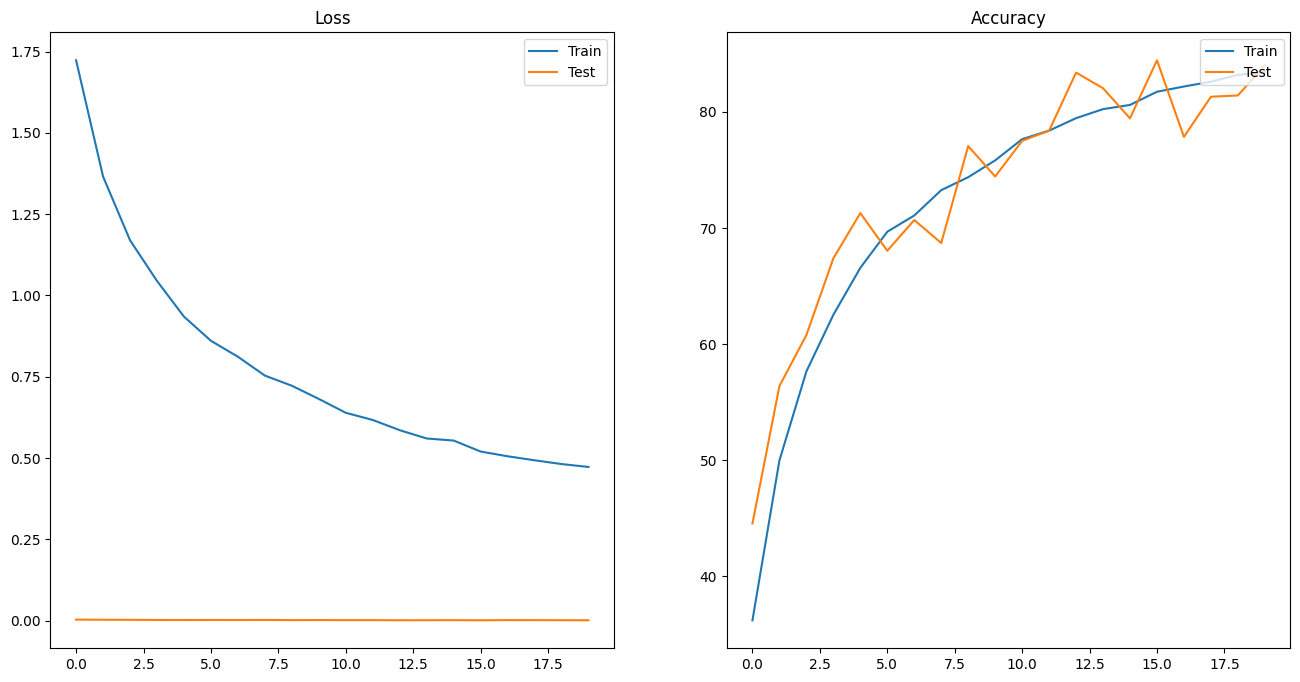

In [17]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [18]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show Misclassified images


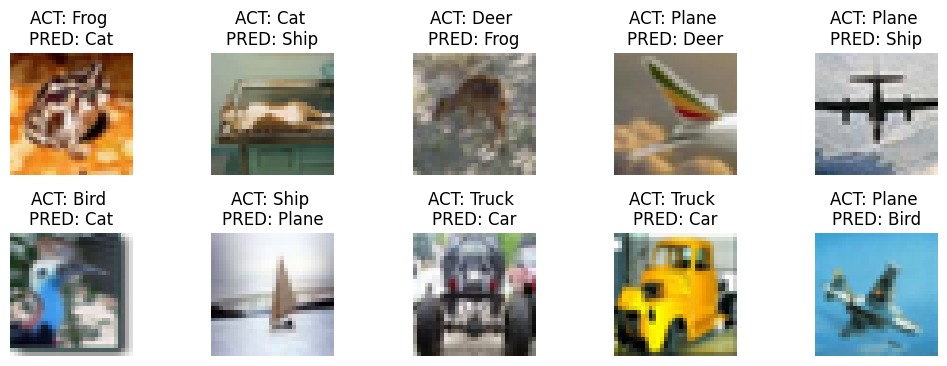

In [19]:
# Plot misclassified images
fig, axs = plot_misclassified_images(data=misclassified_image_data, class_label=classes, num_images=10)
plt.show()
# plt.savefig("Misclassified Images.png")

## GradCAM (Misclassified)


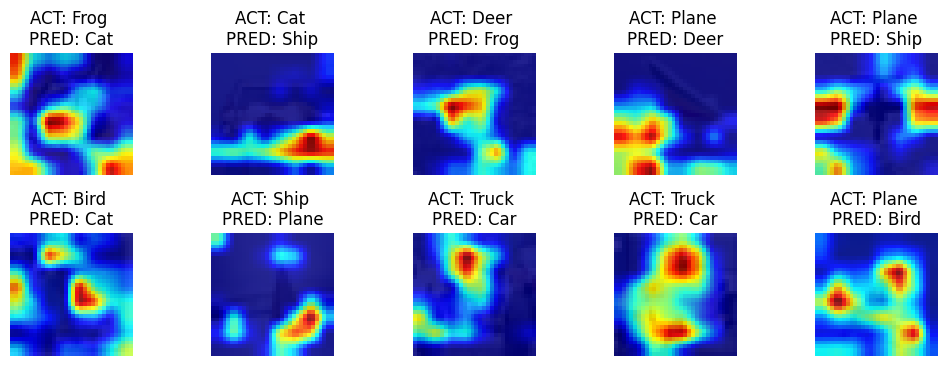

In [20]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    # Decided using model summary so that dimensions > 7x7
    target_layers=[model.layer3[-1]],
    device=device_support,
    targets=None,
    num_images=10,
    image_weight=0.15,
)
plt.show()
# plt.savefig("GradCAM Images.png")